In [1]:
!pip install utm

  Using cached utm-0.7.0-py3-none-any.whl


In [2]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization
import ipyleaflet
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns


# Data Science
import numpy as np
import pandas as pd

# Feature Engineering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score,classification_report,confusion_matrix

# Planetary Computer Tools
import pystac
import pystac_client
import odc
from pystac_client import Client
from pystac.extensions.eo import EOExtension as eo
from odc.stac import stac_load
import planetary_computer as pc
pc.settings.set_subscription_key('100bbb6552514f27a2e52ef1be8d93b6')  # SJ's primary key

# Others
import requests
import rich.table
import utils
from itertools import cycle
from tqdm import tqdm
import xarray as xr
tqdm.pandas()

In [ ]:
#Read Data
crop_presence_data = pd.read_csv("Crop_Location_Data.csv")
crop_presence_data

In [ ]:
crop_presence_data[crop_presence_data['Latitude and Longitude'].str.contains('10.324635504740822, 105.25572266405916')]

In [ ]:
crop_presence_data.info()

In [ ]:
# Check for class imbalance
sns.countplot(x=crop_presence_data['Class of Land'])
plt.show()

In [ ]:
crop_data = utils.convert_coordinates(crop_presence_data, 'Latitude and Longitude')
crop_data.head(11)

In [19]:
def get_sentinel_data(latlong,time_slice,assets):
    '''
    Returns VV and VH values for a given latitude and longitude 
    Attributes:
    latlong - A tuple with 2 elements - latitude and longitude
    time_slice - Timeframe for which the VV and VH values have to be extracted
    assets - A list of bands to be extracted
    '''

    #latlong=latlong.replace('(','').replace(')','').replace(' ','').split(',')
    box_size_deg = 0.0008 # Surrounding box in degrees, yields approximately 5x5 pixel region

    min_lon = float(latlong[1])-box_size_deg/2
    min_lat = float(latlong[0])-box_size_deg/2
    max_lon = float(latlong[1])+box_size_deg/2
    max_lat = float(latlong[0])+box_size_deg/2

    bbox_of_interest = (min_lon, min_lat, max_lon, max_lat)
    time_of_interest = time_slice

    catalog = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    
    search = catalog.search(collections=["sentinel-1-rtc"], bbox=bbox_of_interest, datetime=time_of_interest)
    
    items = list(search.get_all_items())
    bands_of_interest = assests
    data = stac_load([items[0]], patch_url=pc.sign, bbox=bbox_of_interest).isel(time=0)
    vh = data["vh"].median().to_numpy()
    vv = data["vv"].median().to_numpy()
    
    return vh,vv

In [70]:
import datetime
from dateutil.relativedelta import relativedelta
from tqdm import tqdm
import pandas as pd

# Define start and end dates
start_date = datetime.date(2022, 9, 1)
end_date = datetime.date(2022, 12, 1)

# Define assets to collect
assets = ['vh', 'vv']

# Define list to store data
data = []

# Iterate over range of dates
while start_date <= end_date:
    next_date = start_date + relativedelta(months=+1)
    time_slice = f'{start_date}/{next_date}'
    for coordinates in tqdm(crop_presence_data['Latitude and Longitude']):
        vv, vh = get_sentinel_data(coordinates, time_slice, assets)
        data.append([time_slice, vv, vh])
    start_date = next_date

# Convert list to DataFrame and save to file
columns = ['date'] + assets
data_vh_vv = pd.DataFrame(data, columns=columns)
data_vh_vv.to_csv('data_2022-09-01_2022-12-01.csv', index=False)

100%|██████████| 600/600 [01:56<00:00,  5.14it/s]


In [3]:
data_1 = pd.read_csv('data_2022-01-01_2022-04-01.csv')
data_2 = pd.read_csv('data_2022-05-01_2022-08-01.csv')
data_3 = pd.read_csv('data_2022-09-01_2022-12-01.csv')

In [4]:
data_df = pd.concat([data_1, data_2, data_3], axis=0)
data_df.shape

(7200, 3)

In [5]:
data_df.head()

date        vh        vv
0  2022-01-01/2022-02-01  0.027253  0.141300
1  2022-01-01/2022-02-01  0.019327  0.398268
2  2022-01-01/2022-02-01  0.033112  0.143685
3  2022-01-01/2022-02-01  0.033152  0.121286
4  2022-01-01/2022-02-01  0.022331  0.205135

In [6]:
data_df.isna().sum().sum()

0

RVI(v) = (4*VH)/(VV+VH)

In [7]:
def calculate_rvi(vh, vv) -> float:
    dop = (vv / (vv + vh))
    m = 1 - dop
    return (np.sqrt(dop))*((4*vh)/(vv + vh))
# TypeError: loop of ufunc does not support argument 0 of type numpy.float64 which has no callable sqrt method

In [8]:
data_df = data_df.assign(rvi = lambda x: ((4*x.vh)/(x.vv+x.vh)))

In [9]:
# Calculate moving average with a window of 7 days
def calculate_ma(x, period) -> float:
    return x.rolling(window=period).mean()

In [10]:
data_df = data_df.assign(rvi_ma = lambda x: calculate_ma(x.rvi, 7))

In [11]:
data_df2 = data_df

new_index = [i % 600 for i in range(len(data_df2))]

# Assign the new index values to the DataFrame
data_df2['field'] = new_index
data_df2 = data_df2.set_index(['field', 'date'])

In [78]:
data_df2.head()

vh        vv       rvi  rvi_ma
field date                                                       
0     2022-01-01/2022-02-01  0.027253  0.141300  0.646754     NaN
1     2022-01-01/2022-02-01  0.019327  0.398268  0.185127     NaN
2     2022-01-01/2022-02-01  0.033112  0.143685  0.749143     NaN
3     2022-01-01/2022-02-01  0.033152  0.121286  0.858644     NaN
4     2022-01-01/2022-02-01  0.022331  0.205135  0.392697     NaN

In [37]:
crop_field = pd.read_csv('Crop_Location_Data.csv')
crop_field.shape

(600, 2)

In [218]:
crop_field.head()

Latitude and Longitude Class of Land
0   (10.323727047081501, 105.2516346045924)          Rice
1  (10.322364360592521, 105.27843410554115)          Rice
2  (10.321455902933202, 105.25254306225168)          Rice
3  (10.324181275911162, 105.25118037576274)          Rice
4  (10.324635504740822, 105.27389181724476)          Rice

In [260]:
df = data_df.merge(crop_field, left_on='field_index', right_on=crop_field.index)
df.shape

(7200, 8)

In [261]:
df = df.drop('Latitude and Longitude', axis=1)
df.shape

(7200, 7)

In [262]:
df = df.rename({'Class of Land':'target'}, axis=1)
df.head()

date        vh        vv       rvi    rvi_ma  field_index  \
0  2022-01-01/2022-02-01  0.027253  0.141300  0.646754       NaN            0   
1  2022-02-01/2022-03-01  0.037834  0.129970  0.901852  0.841573            0   
2  2022-03-01/2022-04-01  0.031183  0.080205  1.119797  0.807760            0   
3  2022-04-01/2022-05-01  0.007492  0.181525  0.158537  0.696798            0   
4  2022-05-01/2022-06-01  0.027550  0.106956  0.819285  0.883964            0   

  target  
0   Rice  
1   Rice  
2   Rice  
3   Rice  
4   Rice

In [263]:
import xarray as xr

ds = df.set_index(['field_index', 'date', 'target']).to_xarray()
ds.set_coords('date')

<xarray.Dataset>
Dimensions:      (field_index: 600, date: 12, target: 2)
Coordinates:
  * field_index  (field_index) int64 0 1 2 3 4 5 6 ... 594 595 596 597 598 599
  * date         (date) object '2022-01-01/2022-02-01' ... '2022-12-01/2023-0...
  * target       (target) object 'Non Rice' 'Rice'
Data variables:
    vh           (field_index, date, target) float64 nan 0.02725 ... 0.04236 nan
    vv           (field_index, date, target) float64 nan 0.1413 ... 0.2872 nan
    rvi          (field_index, date, target) float64 nan 0.6468 ... 0.5141 nan
    rvi_ma       (field_index, date, target) float64 nan nan nan ... 0.7964 nan

In [264]:
# Save to disk
# ds.to_netcdf('data.nc')

In [3]:
# Load from disk
import xarray as xr

ds = xr.open_dataset("data.nc")
ds

<xarray.Dataset>
Dimensions:      (field_index: 600, date: 12, target: 2)
Coordinates:
  * field_index  (field_index) int64 0 1 2 3 4 5 6 ... 594 595 596 597 598 599
  * date         (date) object '2022-01-01/2022-02-01' ... '2022-12-01/2023-0...
  * target       (target) object 'Non Rice' 'Rice'
Data variables:
    vh           (field_index, date, target) float64 ...
    vv           (field_index, date, target) float64 ...
    rvi          (field_index, date, target) float64 ...
    rvi_ma       (field_index, date, target) float64 ...

In [7]:
ds.drop('target')

<xarray.Dataset>
Dimensions:      (field_index: 600, date: 12, target: 2)
Coordinates:
  * field_index  (field_index) int64 0 1 2 3 4 5 6 ... 594 595 596 597 598 599
  * date         (date) object '2022-01-01/2022-02-01' ... '2022-12-01/2023-0...
Dimensions without coordinates: target
Data variables:
    vh           (field_index, date, target) float64 nan 0.02725 ... 0.04236 nan
    vv           (field_index, date, target) float64 nan 0.1413 ... 0.2872 nan
    rvi          (field_index, date, target) float64 nan 0.6468 ... 0.5141 nan
    rvi_ma       (field_index, date, target) float64 nan nan nan ... 0.7964 nan

In [6]:
df_full = ds.to_dataframe()
df_full.shape

(14400, 4)

In [60]:
df_full.head(25)

vh        vv       rvi  \
field_index date                  target                                   
0           2022-01-01/2022-02-01 Non Rice       NaN       NaN       NaN   
                                  Rice      0.027253  0.141300  0.646754   
            2022-02-01/2022-03-01 Non Rice       NaN       NaN       NaN   
                                  Rice      0.037834  0.129970  0.901852   
            2022-03-01/2022-04-01 Non Rice       NaN       NaN       NaN   
                                  Rice      0.031183  0.080205  1.119797   
            2022-04-01/2022-05-01 Non Rice       NaN       NaN       NaN   
                                  Rice      0.007492  0.181525  0.158537   
            2022-05-01/2022-06-01 Non Rice       NaN       NaN       NaN   
                                  Rice      0.027550  0.106956  0.819285   
            2022-06-01/2022-07-01 Non Rice       NaN       NaN       NaN   
                                  Rice      0.024748  0.063436  1.122568   
            2022-07-01/2022-08-01 Non Rice       NaN       NaN       NaN   
                                  Rice      0.013338  0.081255  0.564006   
            2022-08-01/2022-09-01 Non Rice       NaN       NaN       NaN   
                                  Rice      0.007246  0.121437  0.225241   
            2022-09-01/2022-10-01 Non Rice       NaN       NaN       NaN   
                                  Rice      0.026906  0.047020  1.455845   
            2022-10-01/2022-11-01 Non Rice       NaN       NaN       NaN   
                                  Rice      0.029724  0.067019  1.228993   
            2022-11-01/2022-12-01 Non Rice       NaN       NaN       NaN   
                                  Rice      0.005701  0.054562  0.378394   
            2022-12-01/2023-01-01 Non Rice       NaN       NaN       NaN   
                                  Rice      0.007959  0.195945  0.156125   
1           2022-01-01/2022-02-01 Non Rice       NaN       NaN       NaN   

                                              rvi_ma  
field_index date                  target              
0           2022-01-01/2022-02-01 Non Rice       NaN  
                                  Rice           NaN  
            2022-02-01/2022-03-01 Non Rice       NaN  
                                  Rice      0.841573  
            2022-03-01/2022-04-01 Non Rice       NaN  
                                  Rice      0.807760  
            2022-04-01/2022-05-01 Non Rice       NaN  
                                  Rice      0.696798  
            2022-05-01/2022-06-01 Non Rice       NaN  
                                  Rice      0.883964  
            2022-06-01/2022-07-01 Non Rice       NaN  
                                  Rice      0.803519  
            2022-07-01/2022-08-01 Non Rice       NaN  
                                  Rice      0.715134  
            2022-08-01/2022-09-01 Non Rice       NaN  
                                  Rice      0.668195  
            2022-09-01/2022-10-01 Non Rice       NaN  
                                  Rice      0.841399  
            2022-10-01/2022-11-01 Non Rice       NaN  
                                  Rice      0.848658  
            2022-11-01/2022-12-01 Non Rice       NaN  
                                  Rice      0.722617  
            2022-12-01/2023-01-01 Non Rice       NaN  
                                  Rice      0.645882  
1           2022-01-01/2022-02-01 Non Rice       NaN

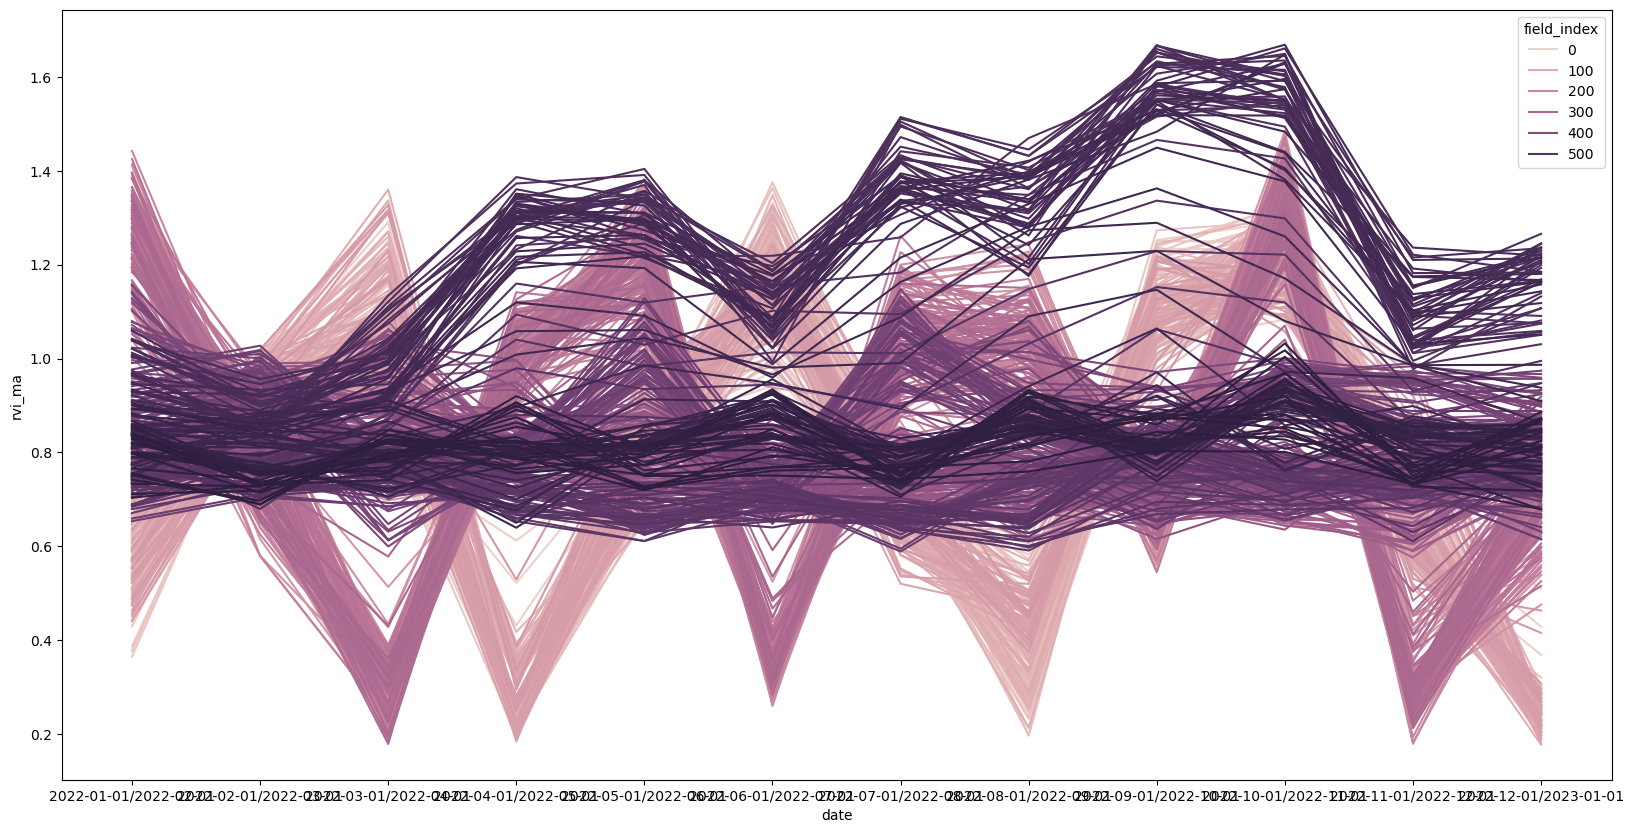

In [245]:
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(data=df_full, x="date", y="rvi_ma", hue="field_index")

fig.savefig("data.png") 

In [258]:
df_rice = ds.sel(target='Rice').to_dataframe()
df_rice.shape

(7200, 5)

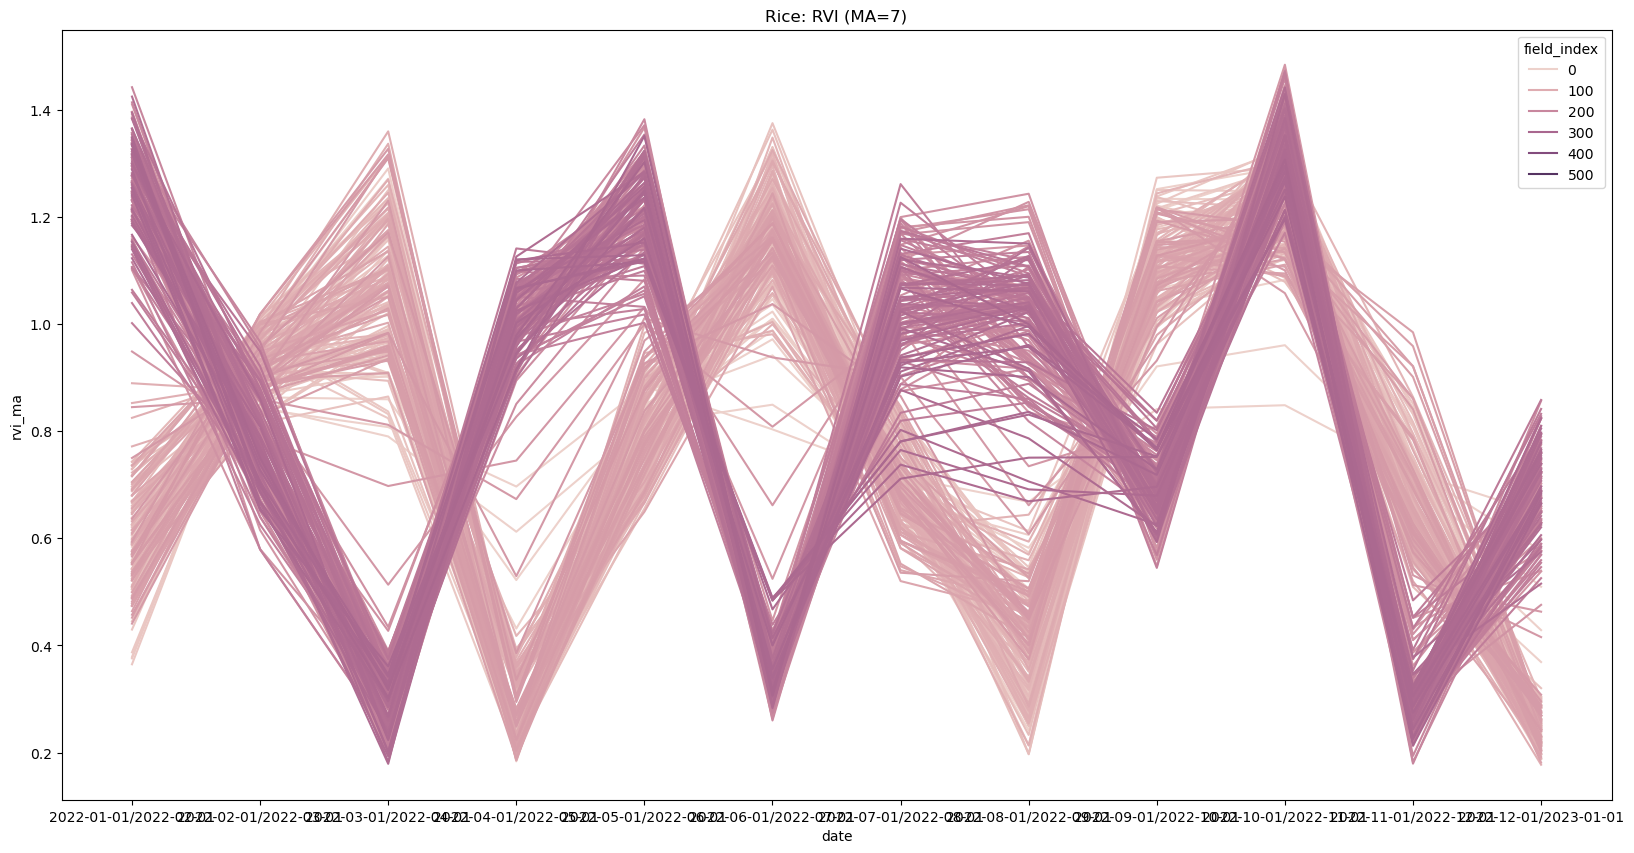

In [259]:
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(data=df_rice, x="date", y="rvi_ma", hue="field_index").set(title='Rice: RVI (MA=7)')

fig.savefig("data_rice.png") 

In [255]:
df_non_rice = ds.sel(target='Non Rice').to_dataframe()
df_non_rice.shape

(7200, 5)

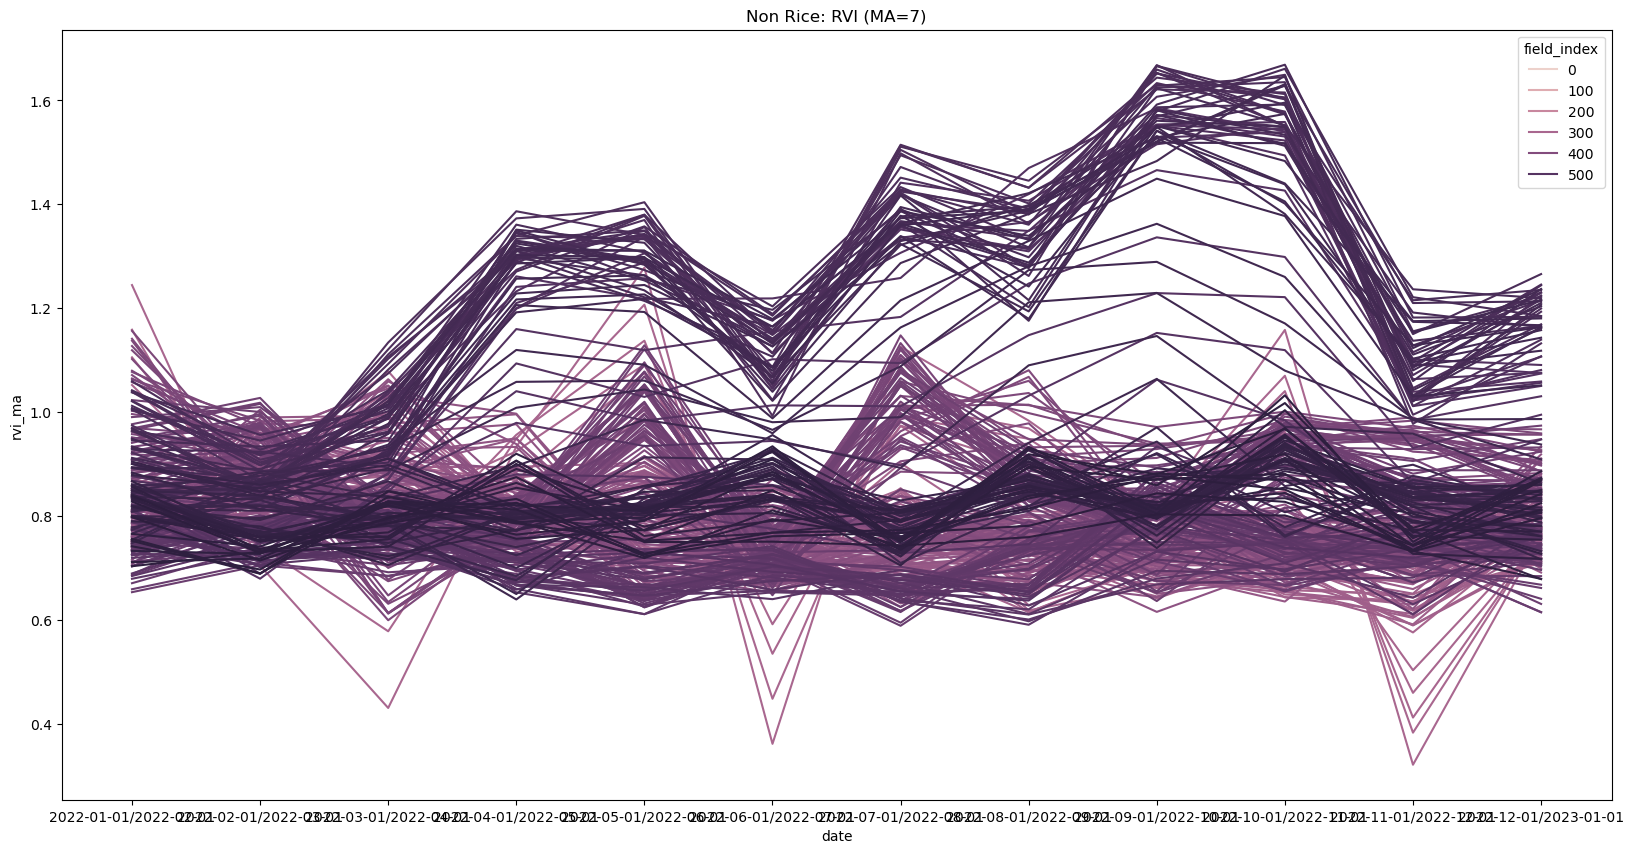

In [256]:
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(20, 10))

sns.lineplot(data=df_non_rice, x="date", y="rvi_ma", hue="field_index").set(title='Non Rice: RVI (MA=7)')

fig.savefig("data_non_rice.png") 

In [12]:
%pip install tslearn

  Using cached tslearn-0.5.3.2-py3-none-any.whl (358 kB)
Note: you may need to restart the kernel to use updated packages.


## Prepeare data

In [56]:
# Assuming your data is in a pandas Series called 'data'
data = pd.Series(data_df2['rvi_ma'].fillna(0))

# Create a DataFrame from your data
df = data.reset_index()

# Pivot the DataFrame to create a 2D array where each row represents a time series
pivot_df = df.pivot_table(values='rvi_ma', index='field', columns='date')

# Convert the pivoted DataFrame to a 2D numpy array
time_series_data = pivot_df.to_numpy()

## Apply Fast Fourier Transform (FFT)

In [38]:
# Apply FFT to the time series data
time_series_data_fft = np.fft.fft(time_series_data)

# Convert complex numbers to magnitude (absolute value)
time_series_data_magnitude = np.abs(time_series_data_fft)

## Apply Moving Average (MA)

In [53]:
# Apply Simple Moving Average (SMA) with a window size of your choice
window_size = 3
time_series_data_sma = pivot_df.rolling(window=window_size, axis=1).mean()

# Drop any rows with NaN values due to the rolling window operation
time_series_data_sma.dropna(axis=1, inplace=True)

# Convert the pivoted DataFrame with SMA to a 2D numpy array
time_series_data = time_series_data_sma.to_numpy()

## Perform the Clustering

Init 1
0.094 --> 0.072 --> 0.076 --> 
Init 2
0.051 --> 0.055 --> 
Init 3
0.045 --> 0.042 --> 0.055 --> 
Init 4
0.047 --> 0.050 --> 
Init 5
0.052 --> 0.054 --> 
Init 6
0.063 --> 0.061 --> 0.065 --> 
Init 7
0.042 --> 0.044 --> 
Init 8
0.046 --> 0.048 --> 
Init 9
0.068 --> 0.059 --> 0.059 --> 0.061 --> 
Init 10
0.070 --> 0.060 --> 0.071 --> 


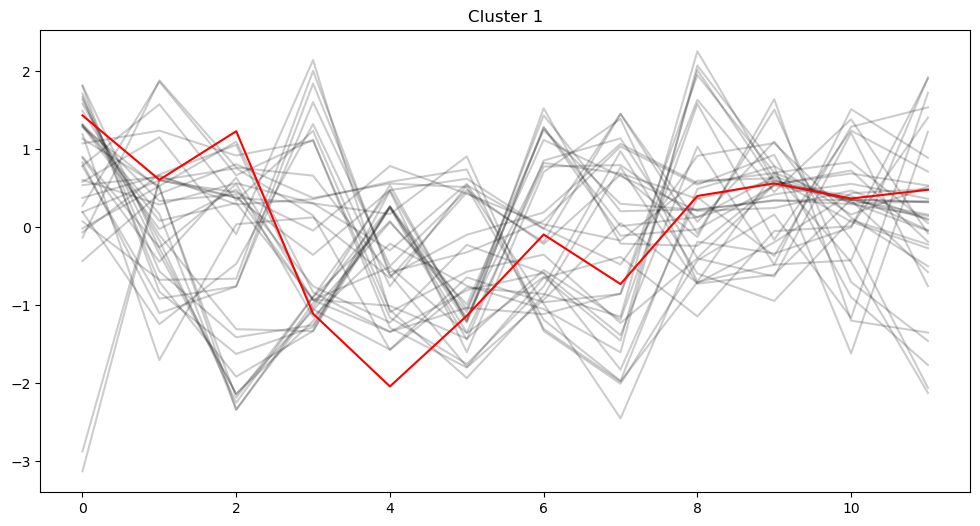

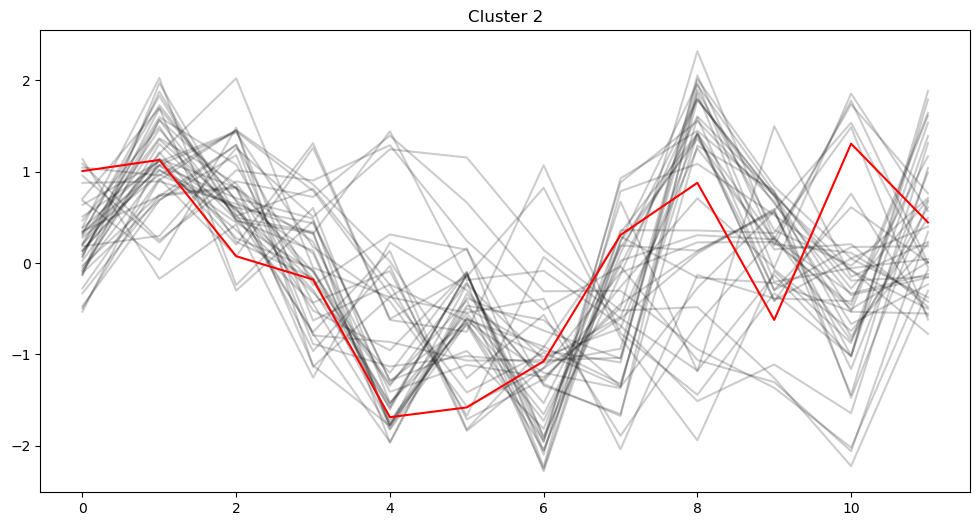

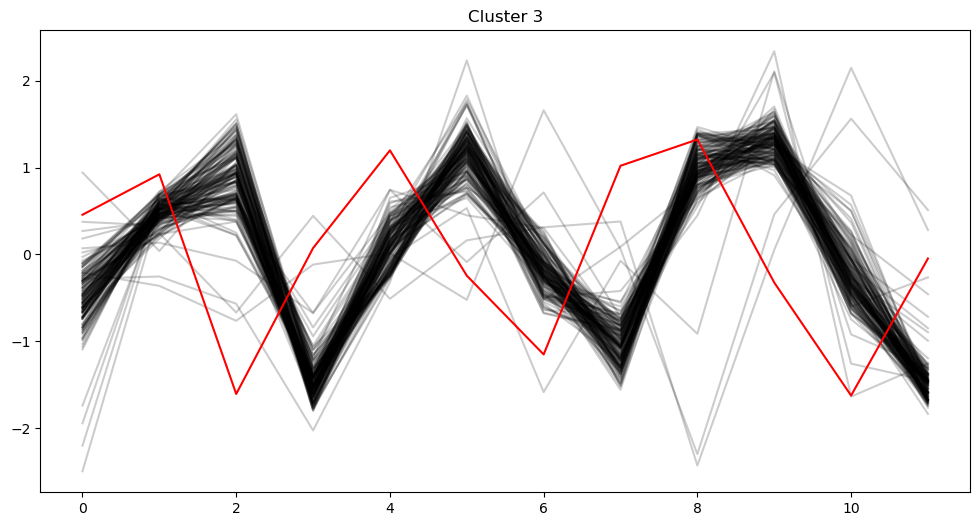

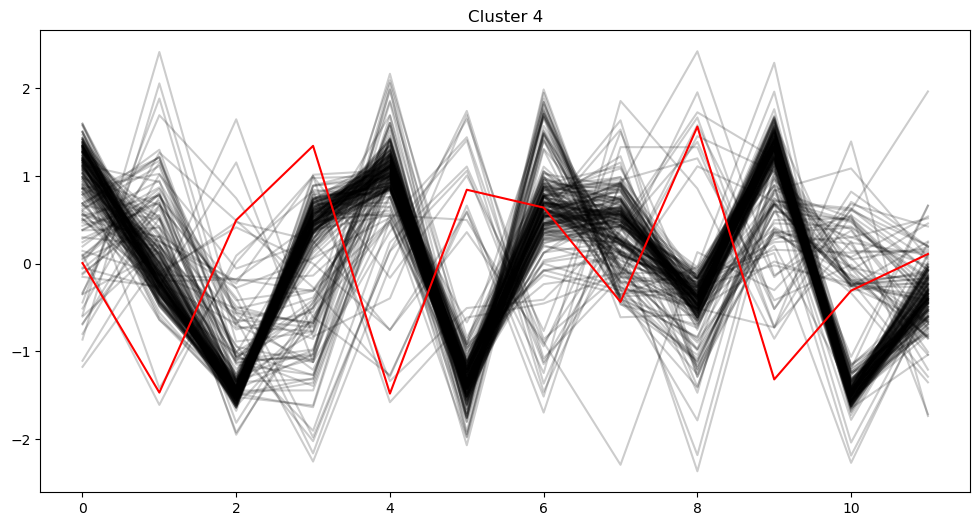

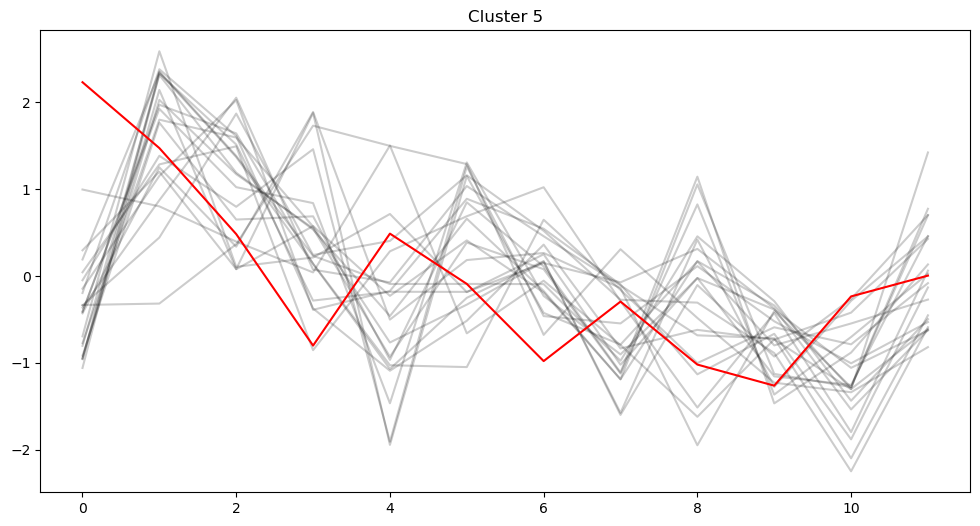

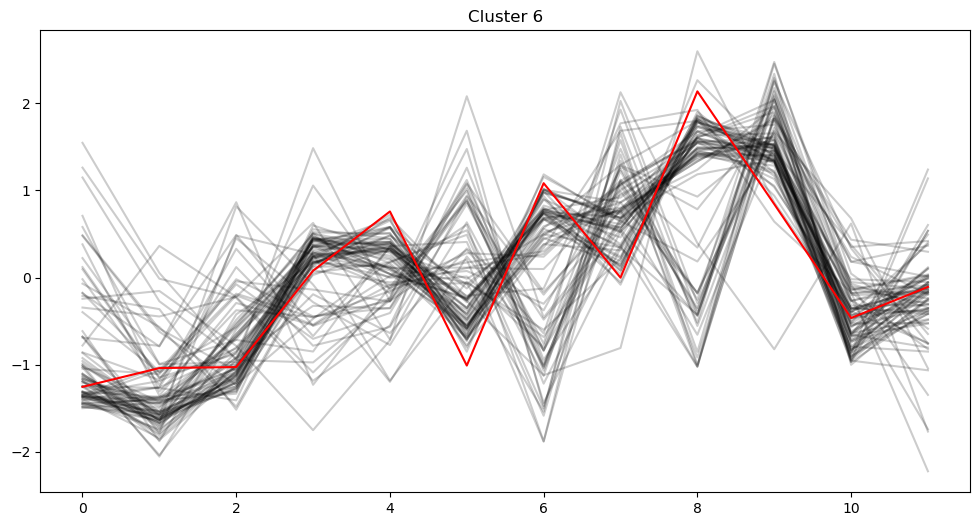

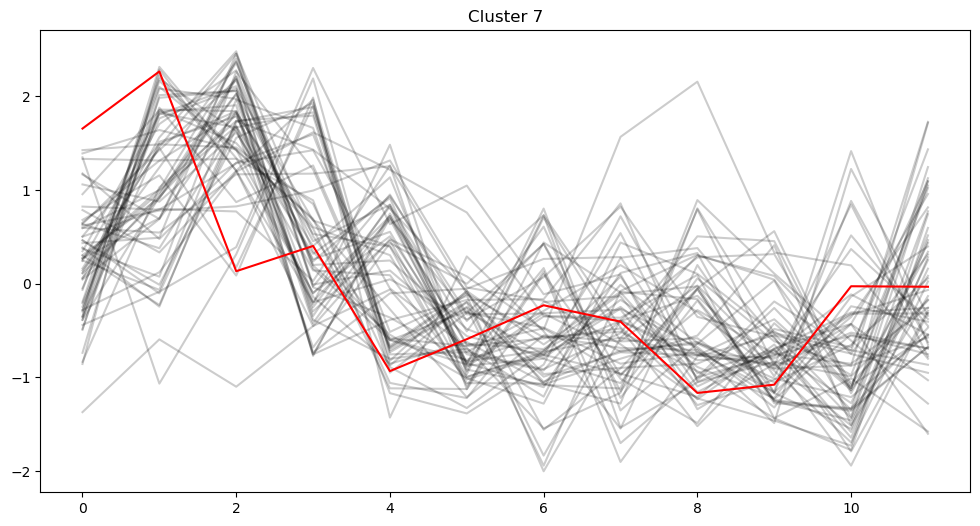

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import KShape

n_clusters = 7

# Scale time series
scaler = TimeSeriesScalerMeanVariance(mu=0.0, std=1.0)
time_series_data_scaled = scaler.fit_transform(time_series_data)

# Perform time series clustering using k-Shape
kshape = KShape(n_clusters=n_clusters, n_init=10, verbose=True, random_state=42)
y_pred = kshape.fit_predict(time_series_data_scaled)

# Plot the time series and their cluster assignments
for yi in range(n_clusters):
    plt.figure(figsize=(12, 6))
    for xx in time_series_data_scaled[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=0.2)
    plt.plot(kshape.cluster_centers_[yi].ravel(), "r-")
    plt.title(f"Cluster {yi + 1}")

plt.show()


## Evaluate

In [58]:
from tslearn.metrics import cdist_dtw
from sklearn.metrics import silhouette_score

# Calculate the distance matrix using Dynamic Time Warping (DTW)
distance_matrix = cdist_dtw(time_series_data_scaled)

# Calculate the silhouette score
silhouette = silhouette_score(distance_matrix, y_pred, metric='precomputed')
print(f"Silhouette score: {silhouette}")

Silhouette score: 0.32511466082369417


## Statistical information

In [59]:
# Calculate statistical information for each cluster
for cluster in range(n_clusters):
    cluster_data = time_series_data[y_pred == cluster]

    # Calculate mean and variance
    cluster_mean = np.mean(cluster_data, axis=0)
    cluster_variance = np.var(cluster_data, axis=0)

    # Calculate autocorrelation
    cluster_data_df = pd.DataFrame(cluster_data)
    cluster_autocorr = cluster_data_df.apply(lambda x: x.autocorr(), axis=1).mean()

    print(f"Cluster {cluster + 1}:")
    print(f"Mean: {cluster_mean}")
    print(f"Variance: {cluster_variance}")
    print(f"Average Autocorrelation: {cluster_autocorr}")
    print("\n")

Cluster 1:
Mean: [0.83158875 0.80958212 0.74025343 0.76431705 0.78586359 0.73521255
 0.81196013 0.78767055 0.82351429 0.83434786 0.81854254 0.79874499]
Variance: [0.06653696 0.00632512 0.00492644 0.00636579 0.01392052 0.00324264
 0.02703508 0.0222995  0.00702164 0.0120896  0.01104777 0.01003269]
Average Autocorrelation: 0.08863556469073164


Cluster 2:
Mean: [0.76077856 0.80621506 0.79042688 0.74649319 0.70840291 0.7160604
 0.68669241 0.71794402 0.78066706 0.75068241 0.72405851 0.76700721]
Variance: [0.00197216 0.00112796 0.00201616 0.00272006 0.0059724  0.00213651
 0.00305724 0.00261305 0.00277328 0.00178633 0.00359954 0.00318243]
Average Autocorrelation: 0.1932585853149543


Cluster 3:
Mean: [0.58457232 0.92586611 1.06606066 0.2767868  0.80204272 1.15581615
 0.70444979 0.41332502 1.10299265 1.19938388 0.67916317 0.26937083]
Variance: [0.01881022 0.00286525 0.01671035 0.0114118  0.00674279 0.01188549
 0.00555528 0.01400981 0.00846149 0.00811787 0.00946094 0.00999862]
Average Autocorre

# Data

In [82]:
# Create a DataFrame to store the time series data and the cluster labels
result_df = pivot_df.copy()
result_df['Cluster'] = y_pred

# Calculate statistical information for each cluster and add to the result DataFrame
for cluster in range(n_clusters):
    cluster_data = time_series_data[y_pred == cluster]

    # Calculate mean and variance
    cluster_mean = np.mean(cluster_data, axis=0)
    cluster_variance = np.var(cluster_data, axis=0)

    # Calculate autocorrelation
    cluster_data_df = pd.DataFrame(cluster_data)
    cluster_autocorr = cluster_data_df.apply(lambda x: x.autocorr(), axis=1).mean()

    # Add statistical information to the result DataFrame
    result_df.loc[result_df['Cluster'] == cluster, 'Mean'] = cluster_mean.mean()
    result_df.loc[result_df['Cluster'] == cluster, 'Variance'] = cluster_variance.mean()
    result_df.loc[result_df['Cluster'] == cluster, 'Autocorrelation'] = cluster_autocorr

# Print the result
result_df.head()

date   2022-01-01/2022-02-01  2022-02-01/2022-03-01  2022-03-01/2022-04-01  \
field                                                                        
0                        0.0               0.841573               0.807760   
1                        0.0               0.846314               0.790300   
2                        0.0               0.863479               0.859740   
3                        0.0               0.895227               0.901925   
4                        0.0               0.908831               0.907711   

date   2022-04-01/2022-05-01  2022-05-01/2022-06-01  2022-06-01/2022-07-01  \
field                                                                        
0                   0.696798               0.883964               0.803519   
1                   0.612413               0.814059               0.849617   
2                   0.522208               0.851382               0.941563   
3                   0.431608               0.834731               0.971780   
4                   0.352323               0.823155               0.988167   

date   2022-07-01/2022-08-01  2022-08-01/2022-09-01  2022-09-01/2022-10-01  \
field                                                                        
0                   0.715134               0.668195               0.841399   
1                   0.695019               0.582343               0.921048   
2                   0.714716               0.501355               1.032338   
3                   0.668375               0.404303               1.065914   
4                   0.644748               0.312362               1.138900   

date   2022-10-01/2022-11-01  2022-11-01/2022-12-01  2022-12-01/2023-01-01  \
field                                                                        
0                   0.848658               0.722617               0.645882   
1                   0.960702               0.728509               0.576973   
2                   1.082728               0.702156               0.509662   
3                   1.119994               0.654099               0.428628   
4                   1.176872               0.589190               0.369074   

date   Cluster      Mean  Variance  Autocorrelation  
field                                                
0            0  0.795133  0.015904         0.088636  
1            0  0.795133  0.015904         0.088636  
2            2  0.764986  0.010336        -0.105744  
3            2  0.764986  0.010336        -0.105744  
4            2  0.764986  0.010336        -0.105744

In [80]:
# Save to disk
result_df.to_csv('time_series_clustering.csv', index=False)